## Rabies Risk Prioritization Machine Learning Model

Welcome to this jupyter notebook tutorial! Jupyter notebook allows you to run one block of code at a time, but note that these need to be run in the order that they appear. The run button can be found on the bar above, just to the left of the stop button, and it will run the block of code that you have currently selected, and any output will be displayed below it. The plus button will add a block of code if there is something you would like to add (for example, adding a block to try a new classifier). The first thing we need to do is import all the modules we will be using.

In [10]:
#import the necessary modules
import csv
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools

from matplotlib.pyplot import savefig
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors,cluster,model_selection
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
%matplotlib inline 

Then we preprocess the data, reading it in from the csv file 'Risk_Data.csv'. This file needs to be saved in the same folder as this jupyter notebook. This file contains columns of input data. The first two columns are the commune and department ID, respectively, and these can be tied to commune and department names according to the IDs found in 'communeID.csv'. If you decide to add inputs to this dataset, add them to the second-to-last column (just make sure that bucketed_scores always remains the last column).

The final column is called 'bucketed_scores', and each of the 63 communes in the dog surveillance system are given a label of 0, 1, or 2. 

In [11]:
#preprocess the risk data
risk_data = []

with open("Risk_Data.csv", "rt") as csvfile:
    reader = csv.reader(csvfile, delimiter = ",")
    next(reader)
    for row in reader:
        for i in range(len(row)):
            try:
                row[i] = int(row[i])
            except:
                try:
                    row[i] = float(row[i])
                except:
                    pass
        risk_data.append(row)
        
print("num communes: " + str(len(risk_data)))

num communes: 140


We then divide the data into labeled and unlabeled lists as the first step in determining our testing and training set.

In [12]:
#labeled and unlabeled (so labeled can be split for training/testing)
labeled = []
unlabeled = []

for i in risk_data:
    if i[-1] != '':
        labeled.append(i)
    else:
        unlabeled.append(i)

#printing number of unlabeled and labeled communes
print(len(unlabeled))
print(len(labeled))

77
63


The functions below provide a modular way to test a classifier and plot the confusion matrix so that it is easy to test and evaluate multiple classifiers. 

The function test_classifier takes in the classifier you would like to use, the input data, and the number of folds that will be used for cross validation. In this example, we use n_splits = 3, so our results will be averaged over 3 folds. The labeled data will be divided into 3 groups of the same size, and stratification ensures that the labels of each group are representative of the entire set of 63. This function will also call plot_confusion_matrix and print a classification_report.

The function plot_confusion_matrix will plot a normalized confusion matrix. This means that it will plot the instances of each combination of predicted and true labels. The percentage is determined by dividing by the number of true labels of each class. The confusion matrix will also be saved as a pdf in the folder where you have this jupyter notebook saved. This will be a higher quality image than what appears here.

In [5]:
def test_classifier(clf, features, n_splits=3):
    """
    Test basic classifier using Stratified K-fold feature selection. The best train/test
    split is used to create the confusion matrix
    """
    Y = np.asarray(labeled)
    folds = list(StratifiedKFold(n_splits, shuffle = True).split(np.asarray(labeled)[:,:-1], Y[:,-1]))
    scores = cross_val_score(clf, features, Y[:,-1], scoring="accuracy", cv=folds)
    print(np.average(scores))
    print(scores)
    total_Y = []
    total_Y_predict = []
    for i in range(n_splits):
        best_fold_train, best_fold_test = folds[i]
        clf.fit(features[best_fold_train], Y[best_fold_train, -1])
        for j in Y[best_fold_test, -1]:
            total_Y.append(j)
        Y_predict = clf.predict(features[best_fold_test])
        for k in Y_predict:
            total_Y_predict.append(k)
  
    cm = confusion_matrix(total_Y, total_Y_predict)
    plot_confusion_matrix(cm)
    print(classification_report(total_Y, total_Y_predict))
    new_predict = clf.predict(np.asarray(unlabeled)[:,:-1])
    print(new_predict)
    #return np.average(scores)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=['low','med','high'], normalize=True):
    """
    Method to visualize confusion matrix
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    savefig('sample.pdf')

Now we can test a classifier. Here we use a GradientBoostingClassifier. The parameters are specific to the classifier, so to adjust these for other models, you will need to look up the sklearn documentation. Here is the documentation for the GradientBoostingClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

The lines commented out below are examples of the other classifiers we tried. You can comment them out and try running each of them to see the results. If you would like to try a new classifier, you will need to add an import statement to be able to use it.

The first number returned is the average accuracy over the 2 folds. The list of 3 numbers below it is the accuracy of each individual fold.

Below this is the classification report. The first column is the risk labels. The second is the precision:
    true positives/(true & false positives)
This is the number of instances correctly predicted to be a label over all the instances predicted to be that label. For example, of all the communes we labeled as high-risk, how many were truly high-risk?
The second column is the recall:
    true positives/(true positives & false negatives)
This is the number of instances correctly predicted to be a label over all the instances that truly are that label. For example, of all the communes we should have predicted to be high-risk, how many did we actually get?
The third column is the f1-score, which is the harmonic mean of precision and recall. And finally, the support size is the number of instances that truly have that label.

Lastly, we have the confusion matrix with the accuracy of each true and predicted label. A perfect classifier would have a dark blue diagonal with 1.00 in those three diagonal boxes and white 0.00s everywhere else. As you can see, we still have some work to do to get there, but this is a step in the right direction.

0.3943722943722943
[0.45454545 0.42857143 0.3       ]
             precision    recall  f1-score   support

        0.0       0.26      0.30      0.28        20
        1.0       0.38      0.36      0.37        28
        2.0       0.64      0.60      0.62        15

avg / total       0.41      0.40      0.40        63

[1. 1. 0. 0. 0. 0. 1. 2. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 2.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 2. 1.
 1. 1. 1. 0. 0. 1. 1. 2. 1. 2. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 1.]


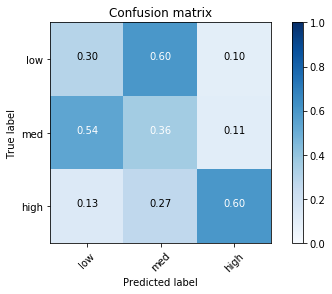

In [8]:
data = np.asarray(labeled)[:,:-1]
test_classifier(GradientBoostingClassifier(n_estimators=200,learning_rate=0.5, max_depth=7), data)

#test_classifier(RandomForestClassifier(), data)
#test_classifier(neighbors.KNeighborsClassifier(n_neighbors = 10), data
#test_classifier(cluster.KMeans(n_clusters=3), data)
#test_classifier(ExtraTreesClassifier(), data)
#test_classifier(AdaBoostClassifier(n_estimators=150,learning_rate=0.3), data)
#test_classifier(DecisionTreeClassifier(), data)
